In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import classification_report
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix, get_complexity,\
                 group_metrics
from surrogate_tree import train_surrogate_tree, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances, plot_tree_leafs_for_class,\
                 tree_to_constraint_matrix, extract_rules, print_rules,\
                 get_pruned_trees, eval_trees

In [2]:
with open('task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [5]:
%%time
trees = []
full_tree = train_surrogate_tree(X, mclass_diff)
trees = get_pruned_trees(full_tree, X, mclass_diff)
tree_it = iter(trees)
len(trees)

CPU times: user 7.91 ms, sys: 2.21 ms, total: 10.1 ms
Wall time: 9.12 ms


4

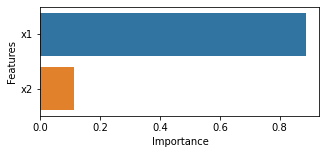

In [6]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

## 2 Leafs

In [7]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.15567567567567567, 1, 2)

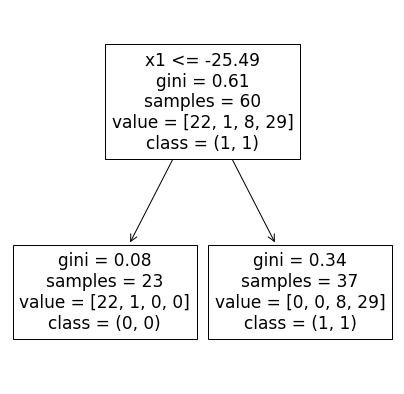

In [9]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [10]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

## 3 Leafs

In [11]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.05333333333333332, 2, 3)

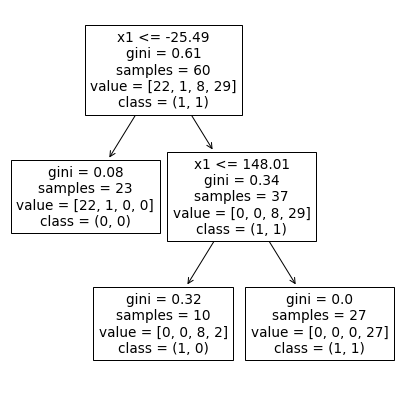

In [13]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [14]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -25.49392032623291 < x1 <= 148.01488494873047 => (1, 0) [0, 0, 8, 2]


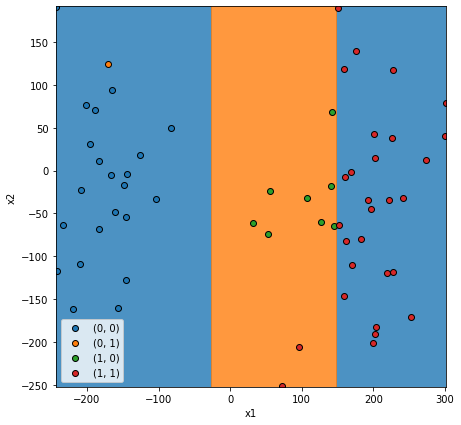

In [15]:
plot_tree_leafs_for_class(tree, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names)

## 4 Leafs

In [16]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01594202898550725, 3, 4)

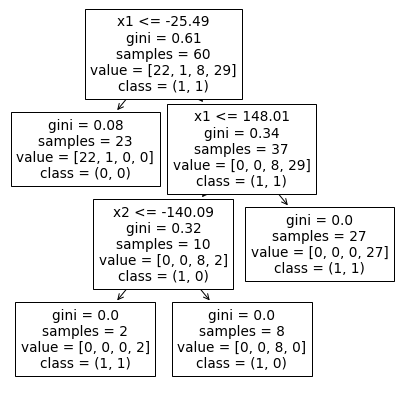

In [18]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [19]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -25.49392032623291 < x1 <= 148.01488494873047 and x2 > -140.0931053161621 => (1, 0) [0, 0, 8, 0]


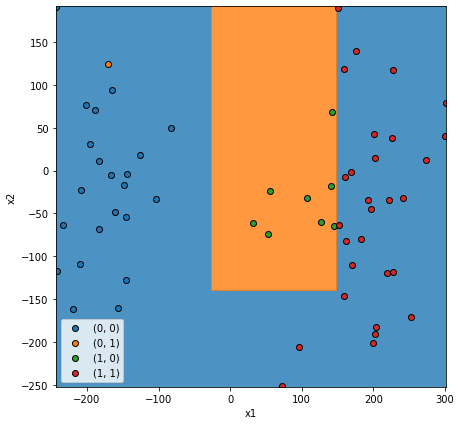

In [20]:
plot_tree_leafs_for_class(tree, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names)

## 6 Leafs

In [21]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 3, 6)

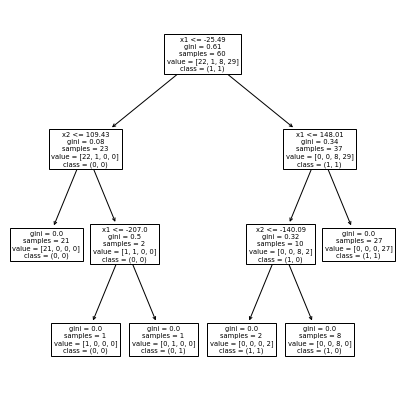

In [23]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [24]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -25.49392032623291 < x1 <= 148.01488494873047 and x2 > -140.0931053161621 => (1, 0) [0, 0, 8, 0]
2. -206.99755096435547 < x1 <= -25.49392032623291 and x2 > 109.43131637573242 => (0, 1) [0, 1, 0, 0]


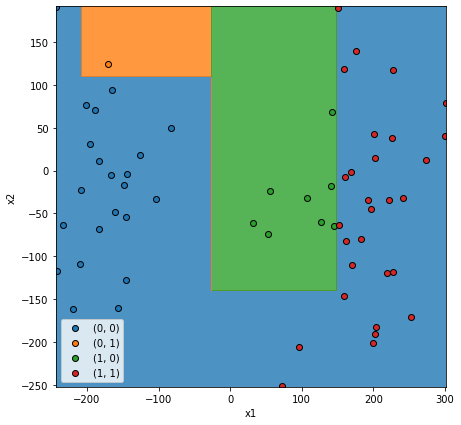

In [25]:
plot_tree_leafs_for_class(tree, comparer.class_names, comparer.difference_class_names, X, mclass_diff, comparer.class_names, feature_names)

# Evaluation

In [8]:
with open('test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [9]:
metrics = eval_trees(trees, feature_names, comparer.class_names, X_test=X_test, y_test=y_test)
metrics

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
"(0, 0)",0.867669,0.869383,0.868525,4050.0,"(0, 0)",2,0.155676,1,1
"(1, 1)",0.341636,1.000000,0.509282,2030.0,"(1, 1)",2,0.155676,1,1
"(0, 0)",0.867669,0.869383,0.868525,4050.0,"(0, 0)",3,0.053333,1,1
"(1, 0)",0.615151,0.994170,0.760028,3259.0,"(1, 0)",3,0.053333,1,2
"(1, 1)",0.971852,0.323153,0.485028,2030.0,"(1, 1)",3,0.053333,1,1
"(0, 0)",0.867669,0.869383,0.868525,4050.0,"(0, 0)",4,0.015942,1,1
"(1, 0)",0.673877,0.994170,0.803273,3259.0,"(1, 0)",4,0.015942,1,3
"(1, 1)",0.929453,0.519212,0.666245,2030.0,"(1, 1)",4,0.015942,2,4
"(0, 0)",0.971026,0.868889,0.917123,4050.0,"(0, 0)",6,0.000000,2,4
"(0, 1)",0.995392,0.653555,0.789041,661.0,"(0, 1)",6,0.000000,1,3


In [10]:
grouped_metrics, constraints = group_metrics(metrics, by='Alpha')

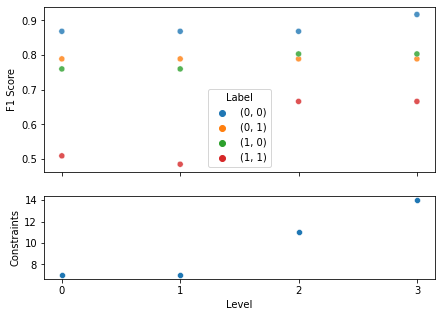

In [11]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('running-baseline-fidelity.pdf')

In [13]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Leafs     Alpha  \
Level                                                                      
0     0  (0, 0)   0.867669  0.869383  0.868525   4050.0    2.0  0.155676   
      1  (0, 1)   0.995392  0.653555  0.789041    661.0    6.0  0.000000   
      2  (1, 0)   0.615151  0.994170  0.760028   3259.0    3.0  0.053333   
      3  (1, 1)   0.341636  1.000000  0.509282   2030.0    2.0  0.155676   
1     0  (0, 0)   0.867669  0.869383  0.868525   4050.0    3.0  0.053333   
      1  (0, 1)   0.995392  0.653555  0.789041    661.0    6.0  0.000000   
      2  (1, 0)   0.615151  0.994170  0.760028   3259.0    3.0  0.053333   
      3  (1, 1)   0.971852  0.323153  0.485028   2030.0    3.0  0.053333   
2     0  (0, 0)   0.867669  0.869383  0.868525   4050.0    4.0  0.015942   
      1  (0, 1)   0.995392  0.653555  0.789041    661.0    6.0  0.000000   
      2  (1, 0)   0.673877  0.994170  0.803273   3259.0    4.0  0.015942   
      3  (1, 1)   0.929453  0.519212  0.666245   2030.0    4.0  0.015942   
3     0  (0, 0)   0.971026  0.868889  0.917123   4050.0    6.0  0.000000   
      1  (0, 1)   0.995392  0.653555  0.789041    661.0    6.0  0.000000   
      2  (1, 0)   0.673877  0.994170  0.803273   3259.0    6.0  0.000000   
      3  (1, 1)   0.929453  0.519212  0.666245   2030.0    6.0  0.000000   

         Rules  Constraints  
Level                        
0     0    1.0          1.0  
      1    1.0          3.0  
      2    1.0          2.0  
      3    1.0          1.0  
1     0    1.0          1.0  
      1    1.0          3.0  
      2    1.0          2.0  
      3    1.0          1.0  
2     0    1.0          1.0  
      1    1.0          3.0  
      2    1.0          3.0  
      3    2.0          4.0  
3     0    2.0          4.0  
      1    1.0          3.0  
      2    1.0          3.0  
      3    2.0          4.0

In [12]:
constraints

Level
0     7.0
1     7.0
2    11.0
3    14.0
Name: Constraints, dtype: float64